In [81]:
# dataloader code
from unet import *
from segmentation_dataset import SegmentationDataset

import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from loguru import logger
import random

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm, trange

def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

train_path = "small_dataset/images/nir/"
val_path = "small_dataset/images/nir/"
test_path = "small_dataset/images/nir/"

train_labels_path = "small_dataset/labels/"
val_labels_path = "small_dataset/labels/"
test_labels_path = "small_dataset/labels/"

train = os.listdir(train_path)
val = os.listdir(val_path)
test = os.listdir(test_path)

random.shuffle(train)
random.shuffle(val)
random.shuffle(test)

train_img_names_index = train[:10]
val_img_names_index = val[:10]
test_img_names_index = test[:2]

labels_one_hot = {}
k = 8
i=0
for label in listdir_nohidden(train_labels_path):
    if label!="storm_damage":
        labels_one_hot[label] = np.zeros((k,))
        labels_one_hot[label][i] = 1
        i+=1

train_dataset = SegmentationDataset(train_img_names_index, labels_one_hot, train_path, train_labels_path, use_cache=True)
val_dataset = SegmentationDataset(val_img_names_index, labels_one_hot, val_path, val_labels_path, use_cache=True)
test_dataset = SegmentationDataset(test_img_names_index, labels_one_hot, test_path, test_labels_path, use_cache=True)

In [82]:
# SETTINGS
Use_GPU = True
Lr = 1e-3
channels = 1  # NIR vs RGB
classes = 9  # outputs (9 labels + 1 background)
maxEpochs = 10
batch_size = 5
shuffle = True

# Code 
if Use_GPU: 
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('cuda used')
    else:
        device = torch.device('cpu')
else:
    device = torch.device('cpu')
# initalize model 

# fix activationfunc, dropout and other settings for model as parameters later 

model = UNet(channels, classes).to(device)

trainValRate = 0.7  # not in use
lrRatesplan = None  # not in use
activation = "relu"  # not in use 

class_weights = torch.FloatTensor([1]+[5]*8).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)

# criterion = torch.nn.CrossEntropyLoss()#ignore_index=0)
optimizer = torch.optim.SGD(model.parameters(), Lr)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

cuda used


In [83]:
trainingAcc = []
trainingLoss = []
validationAcc = []
validationLoss = []

def itterProgress(x, text = "training"):
    return tqdm(enumerate(x), text, total = len(x))

def run(): 
    # itter = itterProgress(trainX)

    for epoch in range(maxEpochs):
        train(epoch)

    torch.save(model.state_dict(), "trained_model.pth")
    

def train(epoch):
    model.train()
    for i, (batch_x, batch_y) in enumerate(train_dataloader):
        indata, target = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        indata = indata.unsqueeze(1)
        out = model(indata)
        out_softmax = torch.softmax(out, 1)
        img = postprocess(out_softmax)
        
        train_acc = iou(img, target)
        loss = criterion(out, target)
        train_loss = loss.item()
        
        trainingAcc.append(train_acc)
        trainingLoss.append(train_loss)

        loss.backward()
        optimizer.step()

        val_acc, val_loss = validate()

        validationAcc.append(val_acc)
        validationLoss.append(val_loss)

        logger.info(f"Epoch {epoch} batch {i+1}/{len(train_dataloader)} loss={train_loss} acc={train_acc} val_loss={val_loss} val_acc={val_acc}")

        if val_loss > np.mean(validationLoss):
            print("Overfitting detected")
            break

def validate():
    model.eval()
    validationAcc_temp = []
    validationLoss_temp = []
    for i, (batch_x, batch_y) in enumerate(val_dataloader):
        indata, target = batch_x.to(device), batch_y.to(device)
        
        with torch.no_grad():
            indata = indata.unsqueeze(1)
            out = model.forward(indata)
            out_softmax = torch.softmax(out, 1)
            img = postprocess(out_softmax)
            
            val_acc = iou(img, target)            
            loss = criterion(out, target)
            val_loss = loss.item()

            validationAcc_temp.append(val_acc)
            validationLoss_temp.append(val_loss)
    
    return np.mean(validationAcc_temp),np.mean(validationLoss_temp)

def postprocess(img):
    img = torch.argmax(img, dim=1)
    img = img.cpu().numpy()
    img = np.squeeze(img)
    img = torch.from_numpy(img).type(torch.int64)
    img = img.to(device)
    # img = re_normalize(img)
    return img

def iou(prediction, target):
    eps = 0
    score = 0

    for k in range(1, 10):
        intersection = torch.sum((prediction==target) * (target==k)).item()
        union = torch.sum(prediction==k).item() + torch.sum(target==k).item()
        iou_k = 0 if intersection == 0 else (intersection + eps) / (union + eps)
        score += iou_k

    score = score / 9
    return score

In [84]:
run()

2021-05-23 22:41:16.538 | INFO     | __main__:train:43 - Epoch 0 batch 1/2 loss=4.342504024505615 acc=0.000718672416045995 val_loss=0.9665387570858002 val_acc=7.574449261794175e-06
2021-05-23 22:41:17.170 | INFO     | __main__:train:43 - Epoch 0 batch 2/2 loss=0.9708023071289062 acc=0.0 val_loss=2.8192734718322754 val_acc=0.010622987649428836


Overfitting detected


2021-05-23 22:41:17.789 | INFO     | __main__:train:43 - Epoch 1 batch 1/2 loss=2.83430552482605 acc=0.010625090306365208 val_loss=2.698339581489563 val_acc=0.0


Overfitting detected


2021-05-23 22:41:18.446 | INFO     | __main__:train:43 - Epoch 2 batch 1/2 loss=2.6830196380615234 acc=0.0 val_loss=1.1850726008415222 val_acc=1.520195801219197e-06
2021-05-23 22:41:19.117 | INFO     | __main__:train:43 - Epoch 2 batch 2/2 loss=1.1884257793426514 acc=3.1904643401800695e-06 val_loss=0.7232558727264404 val_acc=2.6241459439278216e-05
2021-05-23 22:41:19.751 | INFO     | __main__:train:43 - Epoch 3 batch 1/2 loss=0.712999701499939 acc=4.0013419885438496e-05 val_loss=0.6657041311264038 val_acc=0.00013850800885253863
2021-05-23 22:41:20.367 | INFO     | __main__:train:43 - Epoch 3 batch 2/2 loss=0.6708633899688721 acc=0.0001649191578974076 val_loss=0.6446481645107269 val_acc=0.000533406733923022
2021-05-23 22:41:21.006 | INFO     | __main__:train:43 - Epoch 4 batch 1/2 loss=0.6815093755722046 acc=0.0005748762795742662 val_loss=0.6238441467285156 val_acc=0.00026277788942280636
2021-05-23 22:41:21.629 | INFO     | __main__:train:43 - Epoch 4 batch 2/2 loss=0.5858278274536133 a

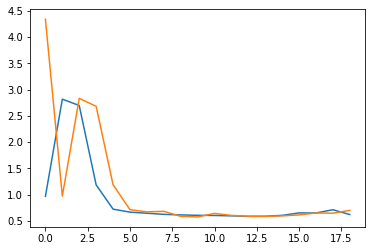

In [85]:
import matplotlib.pyplot as plt
plt.plot(validationLoss)
plt.plot(trainingLoss)

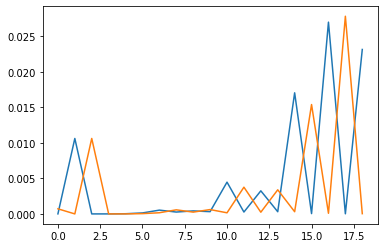

In [86]:
import matplotlib.pyplot as plt
plt.plot(validationAcc)
plt.plot(trainingAcc)

In [58]:
batch_x, batch_y = next(iter(train_dataloader))
x = batch_x[0]
y = batch_y[0]

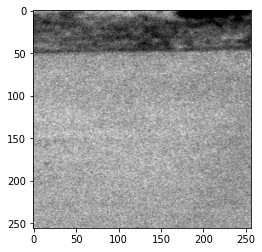

In [59]:
plt.imshow(x,cmap='gray')

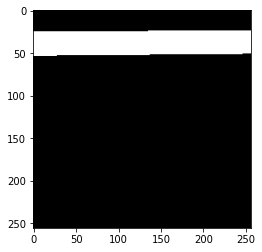

In [60]:
plt.imshow(y, cmap='gray')

In [61]:
batch_x = batch_x.to(device)
indata = batch_x.unsqueeze(1)
out = model(indata)
out_softmax = torch.softmax(out, 1)
img = postprocess(out_softmax)
img

tensor([[[0, 0, 0,  ..., 6, 8, 6],
         [0, 0, 0,  ..., 0, 0, 7],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 7],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 7],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 7],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 7],
         [0, 0, 0,  ..., 0, 0, 7],
         [0, 0, 0,  ..., 0, 0, 7],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 7],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0

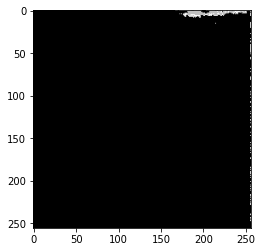

In [65]:
plt.imshow(img[0].cpu().detach().numpy(), cmap='gray')

In [52]:
img[1]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')

In [13]:
# import tensorflow as tf

for i in range(10):
    probs = out[0][i].cpu()
    probs = probs.detach().numpy()
    plt.show()
    plt.imshow(probs, cmap='gray')

NameError: name 'out' is not defined

In [ ]:
from skimage.transform import rescale

x = torch.Tensor([[0, 1, 1, 0], [1, 1, 0, 0], [1, 1, 1, 1], [1, 1, 1, 1]])
print(x)
print(x.shape)

#T = torch.zeros(3, 200, 120)
# print(T.shape)

x = rescale(x, 1/2, order=0, anti_aliasing=False)

print(x.shape)
print(x)
